## Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import random
import torch
from transformers import AutoTokenizer, DataCollatorForLanguageModeling, AutoModelForCausalLM, TrainingArguments, Trainer
from tqdm import tqdm, trange
import math

## Model and Tokenizer Initialization

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained("distilgpt2")
base_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

## Data Preprocessing

In [ ]:
def combine(x, base_tokenizer=base_tokenizer):
    return x["Input"]+" "+"Summary: "+x['Summary']

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Plot_Summary_Dataset')

In [ ]:
df['Input'] = df.apply(combine, axis=1)
df = df['Input']
df.to_csv('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Plot_Summary_DistilGPT2', index=False)

## Data Split

In [ ]:
def encode_sequences(x, base_tokenizer = base_tokenizer):
    # Max length of the input sequence in DistilGPT2 is 1024 tokens
    return base_tokenizer(x, max_length = 1024, truncation=True, add_special_tokens = True)['input_ids']

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Plot_Summary_DistilGPT2')

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)

In [ ]:
train_df = train_df['Input'].apply(encode_sequences)
test_df = test_df['Input'].apply(encode_sequences)

In [ ]:
train_df.dropna(inplace = True)
test_df.dropna(inplace = True)

In [ ]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

## Model Training

In [ ]:
#Setting pad token same as eos token
base_tokenizer.pad_token = base_tokenizer.eos_token

#Initializing Data Collator that forms batches and sends the input in a proper language modeling format to the model for training and evaluation
data_collator = DataCollatorForLanguageModeling(
        tokenizer=base_tokenizer,
        mlm=False,
        return_tensors="pt"
    )

In [ ]:
model_path = '/content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/DistilGPT2'

#Specifying the Training arguments for the model training
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir = True,
    evaluation_strategy="no",
    gradient_accumulation_steps=8,
    num_train_epochs=30,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    fp16=True
)

In [ ]:
# Initializing the trainer

trainer = Seq2SeqTrainer(
    model=base_model,                         # the instantiated  Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=train_df,       # training dataset
    eval_dataset = test_df,
)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Starting the training
trainer.train()

In [ ]:
# Saving the final model
trainer.save_model()

## Model Evaluation (Perplexity)

In [ ]:
eval_results = trainer.evaluate()

In [ ]:
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

## Loading and Testing

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/DistilGPT2")
base_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

In [ ]:
baseline_tokenizer.pad_token = baseline_tokenizer.eos_token

In [ ]:
"""
Format of the input
Title: ADD_TITLE. Genre: ADD_GENRES. Characters: ADD_CHARS. Relations: Neutral: <>. Positive: <>. Negative: <>.  Plot: ADD_PLOT
"""

from transformers import pipeline

input = "Title: Saiyan Warrior. Genre: Action, Adventure, Drama. Characters: Goku, Vegeta, Beerus. Relations: Neutral: <Beerus, Vegeta>. Positive: <Goku, Vegeta>. Negative: <Goku, Beerus>. Plot: Beerus is a god of destruction, who came to Earth to destroy it. Goku and Vegeta in order to protect their family fight and defeat him."
generator = pipeline("text-generation", model=base_model, tokenizer = base_tokenizer)
do_sample = False
num_beams = 1
top_p = 0.9
generator(input, num_beams = num_beams, top_p = top_p, do_sample = do_sample, min_length = 150, max_length = 250)[0]['generated_text'][len(input)+1:]

## BLEU Score Evaluation

In [ ]:
import evaluate
bleu = evaluate.load('bleu')

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained("/content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/DistilGPT2")
base_tokenizer = AutoTokenizer.from_pretrained('distilgpt2')
base_tokenizer.pad_token = base_tokenizer.eos_token

In [ ]:
def encode_input(x, base_tokenizer = base_tokenizer):
  x = str(x)
  idx = x.index("Summary:")
  input = x[:idx]
  summary = x[idx+9:]
  return (input, summary, len(summary))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Visual Story Telling/Dataset - Story Generation/Plot_Summary_DistilGPT2')

In [ ]:
from sklearn.model_selection import train_test_split
df.drop(['Unnamed: 0'], axis=1, inplace=True)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=1)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
test_df = test_df.assign(Summary="", Len=0)

In [ ]:
for idx, row in test_df.iterrows():
    test_df['Input'].iloc[idx], test_df['Summary'].iloc[idx], test_df['Len'].iloc[idx] = encode_input(test_df['Input'].iloc[idx])

In [ ]:
test_df = test_df[test_df['Len']<350]

In [ ]:
test_df.reset_index(drop=True, inplace=True)

In [ ]:
#Greedy, Ancestral and Nucleus
decoding_strats = [[1,1.0, False],[1,1.0, True],[1,0.9, True]]

In [ ]:
import warnings
warnings.simplefilter("ignore")
from transformers import pipeline
generator = pipeline("text-generation", model=base_model, tokenizer = base_tokenizer)
results = []
for x in decoding_strats:
  predictions = []
  references = []
  num_beams, top_p, do_sample = x
  for idx,row in test_df.iterrows():
    references.append(test_df['Summary'].iloc[idx])
    predictions.append(generator(test_df['Input'].iloc[idx], num_beams = num_beams, top_p = top_p, do_sample = do_sample, max_length = len(test_df['Input'].iloc[idx])+test_df["Len"].iloc[idx])[0]['generated_text'][len(test_df['Input'].iloc[idx])+10:])
  base_results = bleu.compute(predictions=predictions, references=references)
  results.append(base_results)
print(results)

## Loss Curve

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_json('/content/drive/MyDrive/Visual Story Telling/Story_Gen_Model/DistilGPT2/checkpoint-16000/trainer_state.json')

In [6]:
def get_epoch(x):
  return x['epoch']

def get_loss(x):
  return x['loss']

In [7]:
df['epoch_number'] = df['log_history'].apply(get_epoch)
df ['loss'] = df['log_history'].apply(get_loss)

Text(0.5, 1.0, 'Training curve DistilGPT2')

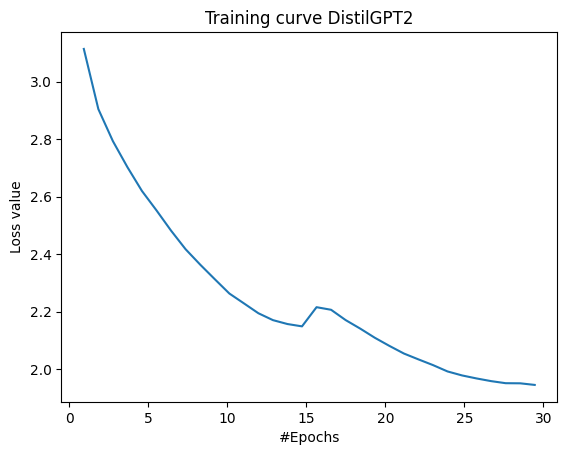

In [8]:
plt.plot(df['epoch_number'].values, df['loss'].values)
plt.xlabel('#Epochs')
plt.ylabel('Loss value')
plt.title('Training curve DistilGPT2')